In [40]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from category_encoders import OneHotEncoder

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [41]:
# Load the dataset
data = pd.read_csv("data/cost-of-housing-in-Lagos.csv")

In [42]:
# Display the first few rows and summary statistics
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53070 entries, 0 to 53069
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         53070 non-null  object
 1   More Info     53070 non-null  object
 2   Price(NGN)    53070 non-null  object
 3   Serviced      53070 non-null  int64 
 4   Newly Built   53070 non-null  int64 
 5   Furnished     53070 non-null  int64 
 6   Bedrooms      53070 non-null  object
 7   Bathrooms     53070 non-null  object
 8   Toilets       53070 non-null  object
 9   Location      53070 non-null  object
 10  Neighborhood  53070 non-null  object
dtypes: int64(3), object(8)
memory usage: 4.5+ MB


In [43]:
data.head()

,Title,More Info,Price(NGN),Serviced,Newly Built,Furnished,Bedrooms,Bathrooms,Toilets,Location,Neighborhood
0,Newly Built 4 Bedroom Semi Detached House With Bq,4 BEDROOM HOUSE FOR RENT,"5,000,000/year",0,1,0,4 beds,4 baths,5 Toilets,Lekki,Agungi
1,Superb 4 Bedroom Semi Detached Duplex With Bq,4 BEDROOM HOUSE FOR RENT,"5,000,000/year",0,1,0,4 beds,4 baths,5 Toilets,Lekki,Other Lekki
2,Furnished 2 Bedroom Terrace Duplex For Rent !!!,2 BEDROOM HOUSE FOR RENT,"3,500,000",1,0,0,2 beds,3 baths,3 Toilets,Lekki,Osapa London
3,2 Bedroom Apartment For Rent,2 BEDROOM HOUSE FOR RENT,"2,700,000",1,1,0,2 beds,3 baths,3 Toilets,Lekki,Ologolo
4,4 Bedroom Terrace Duplex For Rent,4 BEDROOM HOUSE FOR RENT,"4,000,000",1,0,0,4 beds,5 baths,5 Toilets,Lekki,Chevron


In [44]:
# Step 2: Data Cleaning
# Remove rows with missing values
data_cleaned = data.dropna()

In [45]:
# Step 1: Remove '/year'
data_cleaned['Price(NGN)'] = data_cleaned['Price(NGN)'].str.split("/year", expand=True)[0]

# Step 2: Remove commas and other non-numeric characters (e.g., currency symbols)
data_cleaned['Price(NGN)'] = data_cleaned['Price(NGN)'].str.replace(r'[₦,]', '', regex=True)

# Step 3: Convert to numeric
data_cleaned['Price(NGN)'] = pd.to_numeric(data_cleaned['Price(NGN)'], errors='coerce')

In [46]:
print(data_cleaned['Price(NGN)'].dtype)
print(data_cleaned['Price(NGN)'].head())

float64
0    5000000.0
1    5000000.0
2    3500000.0
3    2700000.0
4    4000000.0
Name: Price(NGN), dtype: float64


In [47]:
# Filter apartments costing less than 5,000,000 NGN
data_filtered = data_cleaned[data_cleaned['Price(NGN)'] < 5000000]

In [48]:
data_cleaned.head()

,Title,More Info,Price(NGN),Serviced,Newly Built,Furnished,Bedrooms,Bathrooms,Toilets,Location,Neighborhood
0,Newly Built 4 Bedroom Semi Detached House With Bq,4 BEDROOM HOUSE FOR RENT,5000000.0,0,1,0,4 beds,4 baths,5 Toilets,Lekki,Agungi
1,Superb 4 Bedroom Semi Detached Duplex With Bq,4 BEDROOM HOUSE FOR RENT,5000000.0,0,1,0,4 beds,4 baths,5 Toilets,Lekki,Other Lekki
2,Furnished 2 Bedroom Terrace Duplex For Rent !!!,2 BEDROOM HOUSE FOR RENT,3500000.0,1,0,0,2 beds,3 baths,3 Toilets,Lekki,Osapa London
3,2 Bedroom Apartment For Rent,2 BEDROOM HOUSE FOR RENT,2700000.0,1,1,0,2 beds,3 baths,3 Toilets,Lekki,Ologolo
4,4 Bedroom Terrace Duplex For Rent,4 BEDROOM HOUSE FOR RENT,4000000.0,1,0,0,4 beds,5 baths,5 Toilets,Lekki,Chevron


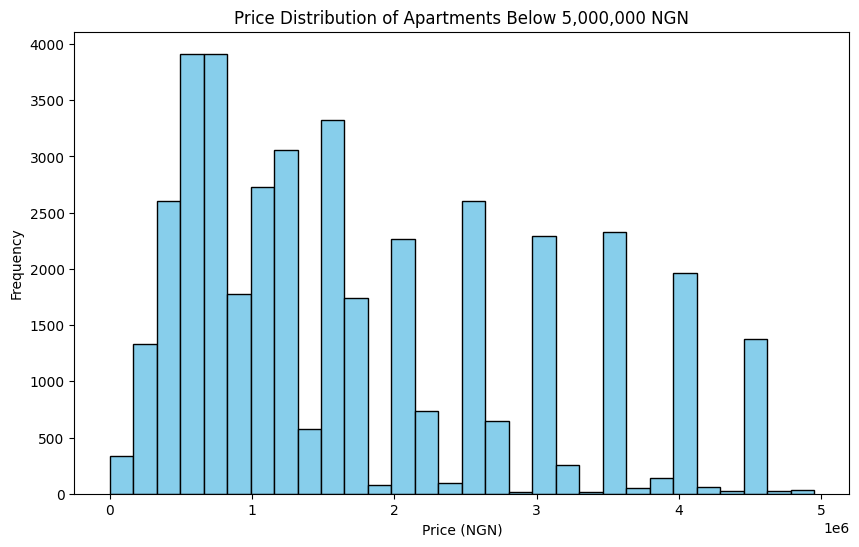

In [49]:
# Price Distribution
plt.figure(figsize=(10, 6))
plt.hist(data_filtered['Price(NGN)'], bins=30, color='skyblue', edgecolor='black')
plt.title('Price Distribution of Apartments Below 5,000,000 NGN')
plt.xlabel('Price (NGN)')
plt.ylabel('Frequency')
plt.show()

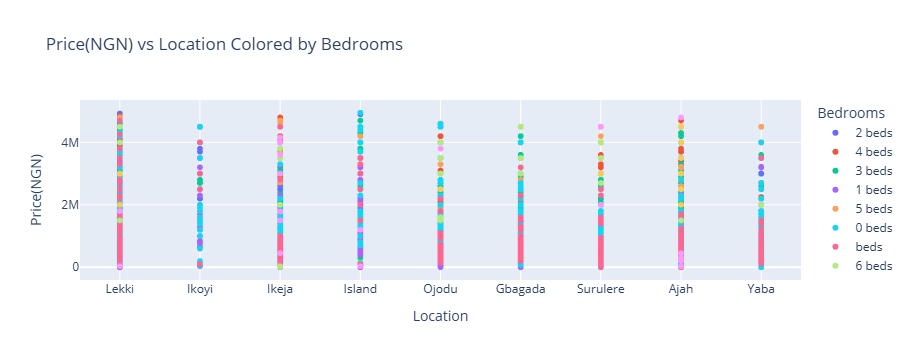

In [50]:
# Visualize relationships with Plotly
fig = px.scatter(data_filtered, x='Location', y='Price(NGN)', color='Bedrooms', title='Price(NGN) vs Location Colored by Bedrooms')
fig.show()

In [51]:
# Handle missing values
data_filtered = data_filtered.dropna()  # Drop rows with missing values

In [52]:
# Clean 'Bedrooms' and 'Bathrooms' columns
def clean_numeric_column(column):
    """Convert text and mixed types to numeric."""
    return column.str.extract(r'(\d+)').astype(float)  # Extract numeric values

data_filtered["Bedrooms"] = clean_numeric_column(data_filtered["Bedrooms"].astype(str))
data_filtered["Bathrooms"] = clean_numeric_column(data_filtered["Bathrooms"].astype(str))

# Drop rows with missing or invalid values after cleaning
data_filtered = data_filtered.dropna(subset=["Bedrooms", "Bathrooms"])


In [53]:
print(data_filtered.dtypes[["Bedrooms", "Bathrooms"]])

Bedrooms     float64
Bathrooms    float64
dtype: object


In [54]:
# Apply one-hot encoding to Location
encoder = OneHotEncoder(cols=["Location"], use_cat_names=True)
data_encoded = encoder.fit_transform(data_filtered)

In [55]:
print(data_encoded.head())

                                              Title                 More Info  \
2   Furnished 2 Bedroom Terrace Duplex For Rent !!!  2 BEDROOM HOUSE FOR RENT   
3                      2 Bedroom Apartment For Rent  2 BEDROOM HOUSE FOR RENT   
4                 4 Bedroom Terrace Duplex For Rent  4 BEDROOM HOUSE FOR RENT   
5                   3 Bedroom Terrace Duplex Houses  3 BEDROOM HOUSE FOR RENT   
11            Nicely Built 4 Bedroom Terrace Duplex  4 BEDROOM HOUSE FOR RENT   

    Price(NGN)  Serviced  Newly Built  Furnished  Bedrooms  Bathrooms  \
2    3500000.0         1            0          0       2.0        3.0   
3    2700000.0         1            1          0       2.0        3.0   
4    4000000.0         1            0          0       4.0        5.0   
5    3500000.0         1            1          0       3.0        3.0   
11   4000000.0         1            0          0       4.0        4.0   

      Toilets  Location_Lekki  Location_Ikoyi  Location_Ikeja  \
2   3 Toi

In [56]:
# Encode categorical features
categorical_features = ["Location"]  
numerical_features = ["Bedrooms", "Bathrooms"]  

In [57]:
# Preprocessing pipeline
# Preprocessor: scale numerical and encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)


In [58]:
# Prepare the data
X = data_filtered[["Location", "Bedrooms", "Bathrooms"]]  
y = data_filtered["Price(NGN)"]

In [59]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
X_train.head()

,Location,Bedrooms,Bathrooms
3727,Lekki,2.0,2.0
38591,Surulere,0.0,0.0
38974,Surulere,2.0,2.0
45483,Ajah,2.0,2.0
26453,Ikeja,0.0,0.0


In [61]:
# Create a pipeline with preprocessing and a Ridge regression model
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", Ridge(alpha=1.0)),
    ]
)

In [62]:
# Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Bedrooms', 'Bathrooms']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Location'])])),
                ('regressor', Ridge())])

In [63]:
# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [66]:
print(y_pred_train[:5])  # Show the first 5 predictions for the training set
print(y_pred_test[:5])   # Show the first 5 predictions for the test set

[2330706.92668158  238329.36490248 1164740.97203553 1208371.62986815
  841734.47854193]
[1867501.12311506 2221319.25570555 1164740.97203553 1654316.65717311
 1685875.58731106]


In [64]:
# Evaluate the model
print("Training Metrics:")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_train, y_pred_train):.2f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_train, y_pred_train)):.2f}")
print(f"R² Score: {r2_score(y_train, y_pred_train):.2f}")

print("\nTesting Metrics:")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred_test):.2f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, y_pred_test)):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred_test):.2f}")

Training Metrics:
Mean Absolute Error (MAE): 625999.81
Root Mean Squared Error (RMSE): 840529.27
R² Score: 0.51

Testing Metrics:
Mean Absolute Error (MAE): 619200.72
Root Mean Squared Error (RMSE): 836328.83
R² Score: 0.51


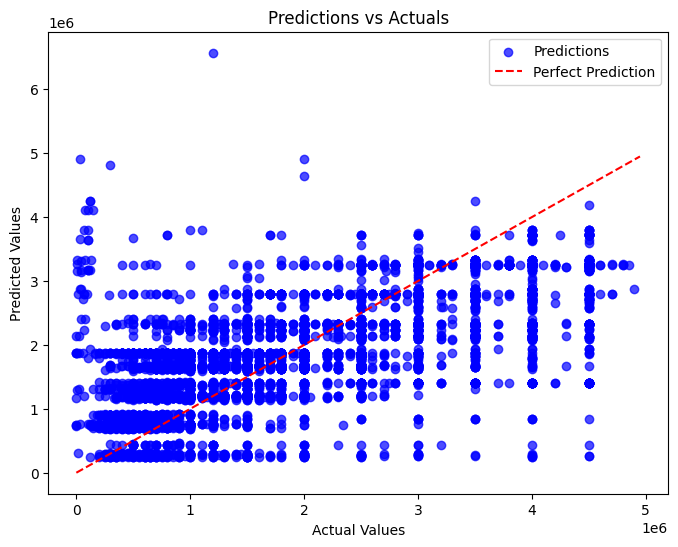

In [65]:
# Visualize Predictions vs Actuals

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.7, color="blue", label="Predictions")
plt.plot([y.min(), y.max()], [y.min(), y.max()], color="red", linestyle="--", label="Perfect Prediction")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predictions vs Actuals")
plt.legend()
plt.show()